In [3]:
import requests
from last_fm_secrets import *
import time
import pandas as pd
import math

headers = {
    "user-agent": func_dict.user_agent
}

In [4]:
class Function_Dictionary_Class:
    user_agent = "Halcyon"
    api_key    = api_key
    secret     = secret
    api_root_url        = "http://ws.audioscrobbler.com/2.0"
    method              = "user.getRecentTracks"
    user                = username
    json                = "json"
    root_key            = "recenttracks"
    attributes          = "@attr"
    tracks              = "track"
    mb_id               = "mbid"
    artist              = "artist"
    artists             = "artists"
    name                = "name"
    album               = "album"
    date                = "date"
    uts                 = "uts"
    text                = "#text"
    idd                 = "id"
    release_date        = "release_date"
    total_tracks        = "total_tracks"
    duration            = "duration_ms"
    explicit            = "explicit"
    popularity          = "popularity"
    danceability        = "danceability"
    energy              = "energy"
    key                 = "key"
    loudness            = "loudness"
    mode                = "mode"
    speechiness         = "speechiness"
    acousticness        = "acousticness"
    instrumentalness    = "instrumentalness"
    liveness            = "liveness"
    valence             = "valence"
    tempo               = "tempo"
    time_signature      = "time_signature"

    class DataFrame_Columns_Class:
        track_id        = "track_id"
        artist_id       = "artist_id"
        album_id        = "album_id"
        track_name      = "track_name"
        artist_name     = "artist_name"
        album_name      = "album_name"
        date            = "date"
        album_release   = "album_release_date"
        album_tracks    = "album_total_tracks"
        duration        = "track_duration"
        explicit        = "explicit"
        popularity      = "track_popularity"
        track_merge     = "track_name_merge"
        artist_merge    = "artist_name_merge"
    
    def __init__(self):
        self.df_columns = self.DataFrame_Columns_Class()

func_dict = Function_Dictionary_Class()

In [2]:
def retrieve_page(user_name, page):
    #Define the payload we will use
    payload = {
        "api_key":  func_dict.api_key,
        "method":   func_dict.method,
        "format":   func_dict.json,
        "limit":    200,
        "user":     user_name,
        "extended": 1,
        "page":     page
    }

    #Use requests to send the payload to the root URL as a JSON.
    r = requests.get(func_dict.api_root_url, headers=headers, params=payload)
    retrieved_json = r.json()
    
    #Retrieve the attributes from the JSON using the proper keys.
    attributes = retrieved_json[func_dict.root_key][func_dict.attributes]

    #Generate an error if the requested page exceeds the number of total pages returned
    if page > int(attributes['totalPages']):
        raise ValueError("Exceeded total number of pages")
    
    #Return the tracks value from the JSON for processing.
    return retrieved_json[func_dict.root_key][func_dict.tracks]

def parse_page(page_data):
    
    #This temporary list functions to store a list of dictionaries that will then be converted into a DataFrame
    temp_list = []

    #For each entry in the input data, which should be the direct output from the retrieve_page function, add a new item
    #to the list
    for entry in page_data:
        temp_list.append({
            func_dict.df_columns.track_name:    entry[func_dict.name],
            func_dict.df_columns.track_id:      entry[func_dict.mb_id],
            func_dict.df_columns.artist_name:   entry[func_dict.artist][func_dict.name],
            func_dict.df_columns.artist_id:     entry[func_dict.artist][func_dict.mb_id],
            func_dict.df_columns.album_name:    entry[func_dict.album][func_dict.text],
            func_dict.df_columns.album_id:      entry[func_dict.album][func_dict.mb_id],
            func_dict.df_columns.date:          entry[func_dict.date][func_dict.uts]
        })
    
    #Once we're done iterating over the input data, turn it into a dataframe, parse the time column into a pandas datetime
    #given that it is given back as seconds in Unix time, then return the resulting dataframe
    return_df = pd.DataFrame(temp_list)
    return_df[func_dict.df_columns.date] = pd.to_datetime(return_df[func_dict.df_columns.date], unit="s")
    return return_df

In [3]:
def retrieve_all_played_tracks(user_name):

    #Retrieve first page, just for attribute examination
    payload = {
        "api_key": func_dict.api_key,
        "method": func_dict.method,
        "format": func_dict.json,
        "limit": 200,
        "user": user_name,
        "extended": 1,
    }
    r = requests.get(func_dict.api_root_url, headers=headers, params=payload)
    retrieved_json = r.json()
    attributes = retrieved_json[func_dict.root_key][func_dict.attributes]
    total_pages = int(attributes['totalPages'])

    #Sets up a list that will hold the resulting DataFrame from the parse_page function. We will concatenate them all
    #together at the end.
    list_of_dataframes = []

    #Use the retrieved total_pages from the attributes to iterate over each. Can be optimized to not retrieve the first
    #page again, but for brevity of the gist this will just re-request the first page.
    for i in range(total_pages):
        #\r at the beginning is solely for compatibility with VSCode's Python Interactive
        print(f"\rPage {i + 1} of {total_pages}", end="")
        time_start = time.time()
        
        #This will loop on a KeyError since that means we received an empty JSON. This will make it try to retrieve the 
        #failed page again, functionally eliminating the possibility of skipped pages.
        while True:
            try:
                page_data = retrieve_page(user_name, i + 1)
                #If the function gets to this point, break out of the loop and continue
                break
            except KeyError:
                continue
        
        #Parse the page and append it to the list of dataframes, then note how much time was taken for the request to be
        #completed
        list_of_dataframes.append(parse_page(page_data))
        time_taken = time.time() - time_start

        #Debounce the requests to have a maximum of 4 functions per second. This value can be edited to work faster at
        #a heavy risk of getting your API key or IP banned.
        if time_taken < 0.25:
            time.sleep(0.25 - time_taken)
        else:
            continue
    
    #Once all pages have been retrieved, concatenate all the dataframes in the list of dataframes and drop their indices
    #to create a new index. Due to the way the data is formatted and the order of retrieval, this will already be set up
    #time-ascending order, with the first song chronologically at index 0.
    return pd.concat(list_of_dataframes, ignore_index=True)


In [4]:
df = pd.read_hdf("listener_df.h5", key="df", parse_dates="date")

In [5]:
df

,track_name,track_id,artist_name,artist_id,album_name,album_id,date
0,Can't Help,2e585c77-48e8-420d-9649-28c188e9fc0f,Parachute,,Can't Help,75fd3dcb-62e2-4a86-b479-c14903d5f57a,2020-12-17 00:55:08
1,Canned Heat,045ef838-e886-4155-ad57-116bda32b97b,Jamiroquai,,Synkronized,2ab9c2ba-8026-4f80-ae12-56450b1165fb,2020-12-17 00:49:36
2,Beach Bones (Feat. Ryan Ross),,More Amor,,Beach Bones (feat. Ryan Ross),,2020-12-17 00:46:10
3,Push Push (Lady Lightning),63aea131-a5f2-41c3-b689-aad85f9c46ec,Bang Camaro,,Bang Camaro,2defe6da-a0d0-419d-83a7-1709e1f3fc62,2020-12-17 00:41:28
4,Procrastinating,4f90aefc-acda-3807-8ba7-4bb829e1936e,Stellar Kart,,Life Is Good: The Best of Stellar Kart,,2020-12-17 00:32:43
...,...,...,...,...,...,...,...
128343,Cupid Shuffle,2907feb9-c3b0-4b03-94af-ba2b38e7ae93,Cupid,,Time For A Change,4bbbe6a2-64a9-4550-8c1d-c9590591b4d7,2013-09-07 11:05:10
128344,Out of My Head,21195bf8-14f7-3601-8064-2026d46ffc28,Theory of a Deadman,,The Truth Is...,4f1279aa-98af-43dd-9b90-8d0d3d00c12d,2013-09-07 11:02:49
128345,Painkiller,039cd1bb-8fc9-3fcc-a902-0af24a1e05cc,Judas Priest,,Judas Priest - The Essential,,2013-09-07 10:56:31
128346,The Anthem,17e96d04-f759-3125-865e-ec4b19f81ba8,Good Charlotte,,The Anthem,29b20ee4-d4df-40d6-98da-7c1d229ee1da,2013-09-07 10:53:36


In [4]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

auth_manager = SpotifyClientCredentials(client_id=spotify_key, client_secret=spotify_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [21]:
def parse_tracks(json):
    new_dict = {
        func_dict.df_columns.album_name:    json[func_dict.album][func_dict.name],
        func_dict.df_columns.album_id:      json[func_dict.album][func_dict.idd],
        func_dict.df_columns.album_release: json[func_dict.album][func_dict.release_date],
        func_dict.df_columns.album_tracks:  json[func_dict.album][func_dict.total_tracks],
        func_dict.df_columns.artist_name:   json[func_dict.artists][0][func_dict.name],
        func_dict.df_columns.artist_id:     json[func_dict.artists][0][func_dict.idd],
        func_dict.df_columns.duration:      json[func_dict.duration],
        func_dict.df_columns.track_name:    json[func_dict.name],
        func_dict.df_columns.track_id:      json[func_dict.idd],
        func_dict.df_columns.explicit:      json[func_dict.explicit],
        func_dict.df_columns.popularity:    json[func_dict.popularity]
    }
    return new_dict

def parse_features(json):
    new_dict = {
        func_dict.idd:                          json[func_dict.idd],
        func_dict.danceability:                 json[func_dict.danceability],
        func_dict.energy:                       json[func_dict.energy],
        func_dict.key:                          json[func_dict.key],
        func_dict.loudness:                     json[func_dict.loudness],
        func_dict.mode:                         json[func_dict.mode],
        func_dict.speechiness:                  json[func_dict.speechiness],
        func_dict.instrumentalness:             json[func_dict.instrumentalness],
        func_dict.acousticness:                 json[func_dict.acousticness],
        func_dict.liveness:                     json[func_dict.liveness],
        func_dict.valence:                      json[func_dict.valence],
        func_dict.tempo:                        json[func_dict.tempo],
        func_dict.time_signature:               json[func_dict.time_signature]
    }
    return new_dict

def parse_multiple_features(response_list):
    return_list = []
    
    for track in response_list:
        try:
            return_list.append(parse_features(track))
        except TypeError:
            continue
    
    return pd.DataFrame(return_list)

def parse_multiple_tracks(response_json):
    list_of_tracks = response_json['tracks']
    return_list = []

    for track in list_of_tracks:
        try:
            return_list.append(parse_tracks(track))
        except TypeError:
            continue

    return pd.DataFrame(return_list)

def start_building_db(input_df):

    #Calculate the number of iterations to run for, minus one
    iterations = math.ceil(len(input_df) / 50) - 1
    #Create an empty list that will contain all the dataframes for each iteration called
    dfs = []

    for i in range(iterations):
        #Slice the list of IDs that will be used. This ensures it will only ever be 50 at a time
        id_list = input_df['track_id'][50 * i : 50 * (i + 1)]
        #retrieve the track JSON for the given list of IDs
        try:
            track_json = sp.tracks(id_list)
        except SpotifyException as e:
            #Retrieve the sleep timer from the 'Retry-After' value in the header, sleep for that amount of time, then
            #try again
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer + .1)
            track_json = sp.tracks(id_list)
        
        #Parse the resulting JSON
        track_df = parse_multiple_tracks(track_json)

        #Do the exact same but for features
        try:
            feature_json = sp.audio_features(id_list)
        except SpotifyException as e:
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer + .1)
            feature_json = sp.audio_features(id_list)

        feature_df = parse_multiple_features(feature_json)

        #Merge the two dataframes, using an inner merge to kick out any tracks which would have incomplete information
        merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")

        dfs.append(merged_df)
    
    #Repeat the above process but for the final tracks, which can be up to 50. NOTE: THIS WILL CREATE DUPLICATES. THAT IS FINE
    final_tracks = input_df['track_id'][-50:]
    try:
        return_json = sp.tracks(final_tracks)
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer + .1)
        return_json = sp.tracks(final_tracks)

    track_df = parse_multiple_tracks(return_json)

    try:
        feature_json = sp.audio_features(final_tracks)
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer + .1)
        feature_json = sp.audio_features(final_tracks)

    feature_df = parse_multiple_features(feature_json)

    merged_df = track_df.merge(feature_df, how="inner", left_on="track_id", right_on="id")
    dfs.append(merged_df)

    #Concatenate all the dataframes, ignore the index, and drop duplicates created in the last step
    return pd.concat(dfs, ignore_index=True).drop_duplicates(keep="first").reset_index(drop=True)


In [26]:
initial_song_list = pd.read_clipboard(header=None)
# initial_song_list[func_dict.df_columns.track_id] = initial_song_list[0].str[31:]
# initial_song_list = initial_song_list[[func_dict.df_columns.track_id]]

In [27]:
initial_song_list

,0
0,https://open.spotify.com/track/4YeKAwFn69ehnci...
1,https://open.spotify.com/track/1PjGQJZWkh4FLkH...
2,https://open.spotify.com/track/53AuxddsgPSlqM6...
3,https://open.spotify.com/track/3uPfVXcjnpOjyzI...
4,https://open.spotify.com/track/21jGcNKet2qwijl...
...,...
3065,https://open.spotify.com/track/6GrvXORJUCRc9W0...
3066,https://open.spotify.com/track/08CGnqCGoDPowDK...
3067,https://open.spotify.com/track/4X71IgEyCwAOXKY...
3068,https://open.spotify.com/track/2bv7c5HdHL6BrlJ...


In [25]:
initial_song_list

,track_id
0,4YeKAwFn69ehnciOfi7Sbf
1,1PjGQJZWkh4FLkH1UKzytl
2,53AuxddsgPSlqM619nJhSd
3,3uPfVXcjnpOjyzI3jb3js4
4,21jGcNKet2qwijlDFuPiPb
...,...
3065,6GrvXORJUCRc9W0onkjiGS
3066,08CGnqCGoDPowDKNTLWisO
3067,4X71IgEyCwAOXKYGYjxriy
3068,2bv7c5HdHL6BrlJt1ASAbc


In [22]:
initial_spotify_df = start_building_db(initial_song_list.loc[~initial_song_list['track_id'].str.contains("%20")])

Expected id of type track but found type Holiday Jakubi//Holiday/224
Expected id of type track but found type Holiday Jakubi//Holiday/224
Expected id of type track but found type Spoonman Soundgarden/Superunknown/Spoonman/246
Expected id of type track but found type Spoonman Soundgarden/Superunknown/Spoonman/246


In [23]:
initial_spotify_df

,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,track_id,explicit,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Conquest,7wZkqIpYypNxkR93nDucc5,2009-01-01,11,Madcon,6c4sUNBgdonFJz8Kx2VsGz,218706,Beggin',4YeKAwFn69ehnciOfi7Sbf,False,...,4,-4.889,0,0.0534,0.000000,0.028400,0.0658,0.431,129.040,4
1,Armistice,3YmsWfVb0BTohLarAlbgFY,2009-07-31,12,Mutemath,1J9Z9bhqkgyqseEi85cbyx,228586,Electrify,1PjGQJZWkh4FLkH1UKzytl,False,...,4,-4.102,0,0.2200,0.000000,0.000122,0.3850,0.367,175.055,4
2,Save Rock And Roll,0EVJX4RlYKuApsAN5CaDa3,2013-01-01,11,Fall Out Boy,4UXqAaa6dQYAk18Lv7PEgX,244960,The Phoenix,53AuxddsgPSlqM619nJhSd,False,...,4,-2.991,0,0.0720,0.000002,0.000539,0.5790,0.410,138.063,4
3,Floored,3jMUfZpBUTZOl91khbj4ic,1997-06-20,13,Sugar Ray,4uN3DsfENc7dp0OLO0FEIb,244134,Fly,3uPfVXcjnpOjyzI3jb3js4,False,...,1,-8.150,1,0.0488,0.225000,0.020200,0.3080,0.674,99.701,4
4,Hollywood's Bleeding,4g1ZRSobMefqF6nelkgibi,2019-09-06,17,Post Malone,246dkjvS1zLTtiykXe5h60,215280,Circles,21jGcNKet2qwijlDFuPiPb,False,...,0,-3.497,1,0.0395,0.002440,0.192000,0.0863,0.553,120.042,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,All Out Everything,3cp10tepg2crOCBO4DYsEe,2010-12-11,10,All Out,3Q9iaulvh7rGoY0H56dXKA,205903,Lights Ft. XV,6GrvXORJUCRc9W0onkjiGS,True,...,0,-5.441,1,0.4320,0.000000,0.040300,0.2070,0.620,158.093,4
3005,It's Only Natural,5bGGtzhY8JtVuv5TTbiDFJ,2009-06-19,12,The Higher,6hALa9u5I9KY2PLC2rzsLE,194813,It's Only Natural,08CGnqCGoDPowDKNTLWisO,False,...,8,-3.279,0,0.0688,0.001370,0.027900,0.0537,0.787,120.021,4
3006,Recoil (Explicit Content U.S. Version),0wMl72AddFnnhtCVNyWx2G,2004-07-13,14,Nonpoint,6BdSOHfQ6kMg0tbAFlXR1z,173306,Broken Bones,4X71IgEyCwAOXKYGYjxriy,False,...,5,-3.638,0,0.0676,0.000989,0.000034,0.0943,0.475,96.054,4
3007,Race You to the Bottom,13eNs79hvWC8FB96ekbAVy,2010-09-28,15,New Medicine,3driPpCh1JEUnPFKGyHXDr,152253,The Takeover,2bv7c5HdHL6BrlJt1ASAbc,True,...,3,-3.424,0,0.0593,0.000000,0.007700,0.2320,0.796,106.505,4


In [24]:
initial_spotify_df

,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,track_id,explicit,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Conquest,7wZkqIpYypNxkR93nDucc5,2009-01-01,11,Madcon,6c4sUNBgdonFJz8Kx2VsGz,218706,Beggin',4YeKAwFn69ehnciOfi7Sbf,False,...,4,-4.889,0,0.0534,0.000000,0.028400,0.0658,0.431,129.040,4
1,Armistice,3YmsWfVb0BTohLarAlbgFY,2009-07-31,12,Mutemath,1J9Z9bhqkgyqseEi85cbyx,228586,Electrify,1PjGQJZWkh4FLkH1UKzytl,False,...,4,-4.102,0,0.2200,0.000000,0.000122,0.3850,0.367,175.055,4
2,Save Rock And Roll,0EVJX4RlYKuApsAN5CaDa3,2013-01-01,11,Fall Out Boy,4UXqAaa6dQYAk18Lv7PEgX,244960,The Phoenix,53AuxddsgPSlqM619nJhSd,False,...,4,-2.991,0,0.0720,0.000002,0.000539,0.5790,0.410,138.063,4
3,Floored,3jMUfZpBUTZOl91khbj4ic,1997-06-20,13,Sugar Ray,4uN3DsfENc7dp0OLO0FEIb,244134,Fly,3uPfVXcjnpOjyzI3jb3js4,False,...,1,-8.150,1,0.0488,0.225000,0.020200,0.3080,0.674,99.701,4
4,Hollywood's Bleeding,4g1ZRSobMefqF6nelkgibi,2019-09-06,17,Post Malone,246dkjvS1zLTtiykXe5h60,215280,Circles,21jGcNKet2qwijlDFuPiPb,False,...,0,-3.497,1,0.0395,0.002440,0.192000,0.0863,0.553,120.042,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,All Out Everything,3cp10tepg2crOCBO4DYsEe,2010-12-11,10,All Out,3Q9iaulvh7rGoY0H56dXKA,205903,Lights Ft. XV,6GrvXORJUCRc9W0onkjiGS,True,...,0,-5.441,1,0.4320,0.000000,0.040300,0.2070,0.620,158.093,4
3005,It's Only Natural,5bGGtzhY8JtVuv5TTbiDFJ,2009-06-19,12,The Higher,6hALa9u5I9KY2PLC2rzsLE,194813,It's Only Natural,08CGnqCGoDPowDKNTLWisO,False,...,8,-3.279,0,0.0688,0.001370,0.027900,0.0537,0.787,120.021,4
3006,Recoil (Explicit Content U.S. Version),0wMl72AddFnnhtCVNyWx2G,2004-07-13,14,Nonpoint,6BdSOHfQ6kMg0tbAFlXR1z,173306,Broken Bones,4X71IgEyCwAOXKYGYjxriy,False,...,5,-3.638,0,0.0676,0.000989,0.000034,0.0943,0.475,96.054,4
3007,Race You to the Bottom,13eNs79hvWC8FB96ekbAVy,2010-09-28,15,New Medicine,3driPpCh1JEUnPFKGyHXDr,152253,The Takeover,2bv7c5HdHL6BrlJt1ASAbc,True,...,3,-3.424,0,0.0593,0.000000,0.007700,0.2320,0.796,106.505,4


In [35]:
initial_merge = df[["track_name", "artist_name", "date"]].merge(initial_spotify_df.drop_duplicates(), how="left", on=[func_dict.df_columns.track_name, func_dict.df_columns.artist_name])
initial_merge

,track_name,artist_name,date,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,track_id,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Can't Help,Parachute,2020-12-17 00:55:08,Can't Help,0Fy31rd6aBdfrF3M4N09rb,2013-01-01,1.0,2PCUhxD40qlMqsKHjTZD2e,204506.0,3PkqKXtkXUffwiGs6H6K71,...,10.0,-3.480,0.0,0.0414,0.000000,0.001950,0.0819,0.7660,122.007,4.0
1,Canned Heat,Jamiroquai,2020-12-17 00:49:36,Synkronized,0rfXEWU67NngRYE58q1aMO,1999-06-08,10.0,6J7biCazzYhU3gM9j1wfid,331733.0,2u5woInaGB7YASEd1CwGBJ,...,5.0,-5.821,1.0,0.1250,0.000207,0.013100,0.0751,0.7730,128.032,4.0
2,Beach Bones (Feat. Ryan Ross),More Amor,2020-12-17 00:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Push Push (Lady Lightning),Bang Camaro,2020-12-17 00:41:28,Bang Camaro,2EW0qzRe2ntiYBerUAgJqr,2007-01-01,12.0,7sB9Netl8x6rYTw0gs1JJ8,281653.0,02YuWD3sBOJa1cnGW1DqCE,...,9.0,-7.097,0.0,0.0948,0.005070,0.001710,0.0630,0.4010,111.931,4.0
4,Procrastinating,Stellar Kart,2020-12-17 00:32:43,We Can't Stand Sitting Down,4E3hrnhsgHifQlL83tu57M,2006-07-25,13.0,5WM2QZxPsbSfFrt4ibSDBi,161320.0,2ca7DN6Edo42tuY2rTPwRk,...,11.0,-3.343,1.0,0.0424,0.000000,0.000066,0.3930,0.7130,95.026,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144520,Painkiller,Judas Priest,2013-09-07 10:56:31,Judas Priest - The Essential,634f0ThTo5tINAaRuCp0Bk,2005,34.0,2tRsMl4eGxwoNabM08Dm4I,365680.0,5z7Gr22ByWTRnWP39M7Hj1,...,1.0,-4.902,0.0,0.1720,0.105000,0.000270,0.3280,0.0871,103.142,4.0
144521,The Anthem,Good Charlotte,2013-09-07 10:53:36,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,14.0,5aYyPjAsLj7UzANzdupwnS,175093.0,0BRHnOFm6sjxN1i9LJrUDu,...,1.0,-3.127,1.0,0.1260,0.000000,0.006660,0.1390,0.8930,177.751,4.0
144522,The Anthem,Good Charlotte,2013-09-07 10:53:36,Greatest Hits,02abrECBsxdR3Ywjy1hCuW,2010-11-12,16.0,5aYyPjAsLj7UzANzdupwnS,174213.0,63t9x6MyYnZ9tYprnk6cty,...,1.0,-3.078,1.0,0.1060,0.000000,0.007490,0.2970,0.9180,88.872,4.0
144523,The Anthem,Good Charlotte,2013-09-07 10:53:36,The Anthem,2kwzEA1chuNvpOeORDkqNs,2003,2.0,5aYyPjAsLj7UzANzdupwnS,174000.0,6sSJMwvxWRXkEcRv1WW1Gx,...,1.0,-3.120,1.0,0.1040,0.000000,0.006640,0.2020,0.8710,88.884,4.0


In [31]:
deduped_spotify_df = initial_spotify_df.sort_values(func_dict.df_columns.album_release).groupby([func_dict.df_columns.track_name, func_dict.df_columns.artist_name]).first().reset_index()

In [32]:
deduped_spotify_df

,track_name,artist_name,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,track_id,explicit,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,"""The Take Over, The Breaks Over""",Fall Out Boy,Infinity On High,0hHopYqXhuvYSHtVyrcb1g,2007-01-01,19,4UXqAaa6dQYAk18Lv7PEgX,213586,3rG8ZkmKHb4Ms6CsSzEITv,False,...,9,-2.563,1,0.0477,0.000020,0.00614,0.0775,0.6700,149.948,4
1,#SELFIE,The Chainsmokers,#SELFIE,3OeA4rJ9XJNAygyNyTc2sI,2014-01-01,1,69GGBxA162lTqCwzJG5jLp,183750,1HOlb9rdNOmy9b1Fakicjo,False,...,0,-3.262,1,0.2490,0.000008,0.01350,0.0770,0.6580,127.956,4
2,'Till I Get There,Lupe Fiasco,Lasers,4Um8wMKUXteqtUlFelOHrg,2011-03-07,12,01QTIT5P1pFP3QnnFSdsJf,203973,4MZTeIw3uRaBB2BiuVKFv6,False,...,1,-6.427,1,0.0465,0.000023,0.02370,0.1180,0.7820,87.008,4
3,(Don't Fear) The Reaper,Blue Öyster Cult,The Essential Blue Öyster Cult,6NNrQJ8ojvbfFzoUjjABo4,1972,14,00tVTdpEhQQw1bqdu8RCx2,308640,2NL4BBBSgypHnxUKmQdYcT,False,...,0,-8.349,1,0.0609,0.002130,0.00127,0.3050,0.5590,141.162,4
4,(Fuck A) Silver Lining,Panic! At The Disco,Say Amen for Silver Linings,2AzBM2be7dJEhOKJBP9FYR,2018-03-21,2,20JZFwl6HVl6yg8a4H3ZqK,168613,7g58rb2dFDCvcmLBwpHR9F,True,...,1,-1.352,0,0.1080,0.000000,0.02720,0.2400,0.7140,105.092,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,push pull,Purity Ring,push pull,4towtAU3ilQhDVA5Ink2KN,2014-12-04,1,1TtJ8j22Roc24e2Jx3OcU4,207809,223pTIXzqcuxzQyAtz5kyo,False,...,5,-8.173,1,0.0489,0.000023,0.00287,0.2450,0.0858,110.354,5
2738,rockstar,Post Malone,rockstar,1YCRXKLDRB0UnbrFUJ4F6e,2017-09-15,1,246dkjvS1zLTtiykXe5h60,218320,1OmcAT5Y8eg5bUPv9qJT4R,True,...,5,-6.631,0,0.0776,0.000127,0.12800,0.1430,0.1410,159.786,4
2739,take me home,After Midnight Project,After Midnight Project,2AMnEB6MQmgzkq6jy7G6nj,2006-07-25,5,1CCtRpOlg6EL0HP9DdEtk4,242560,6rB6HeqN515Hn2BAjz2m3I,False,...,7,-4.744,1,0.0900,0.000015,0.01960,0.2760,0.1890,162.078,4
2740,"thank u, next",Ariana Grande,"thank u, next",684W6NpKllEexqQlGqetCi,2018-11-03,1,66CXWjxzNUsdJxJ2JdwvnR,207333,2rPE9A1vEgShuZxxzR2tZH,True,...,1,-5.642,1,0.0658,0.000000,0.28000,0.1020,0.4350,106.960,4


In [34]:
second_merge = df[["track_name", "artist_name", "date"]].merge(deduped_spotify_df.drop_duplicates(), how="left", on=[func_dict.df_columns.track_name, func_dict.df_columns.artist_name])
second_merge

,track_name,artist_name,date,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,track_id,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Can't Help,Parachute,2020-12-17 00:55:08,Can't Help,0Fy31rd6aBdfrF3M4N09rb,2013-01-01,1.0,2PCUhxD40qlMqsKHjTZD2e,204506.0,3PkqKXtkXUffwiGs6H6K71,...,10.0,-3.480,0.0,0.0414,0.000000,0.001950,0.0819,0.766,122.007,4.0
1,Canned Heat,Jamiroquai,2020-12-17 00:49:36,Synkronized,0rfXEWU67NngRYE58q1aMO,1999-06-08,10.0,6J7biCazzYhU3gM9j1wfid,331733.0,2u5woInaGB7YASEd1CwGBJ,...,5.0,-5.821,1.0,0.1250,0.000207,0.013100,0.0751,0.773,128.032,4.0
2,Beach Bones (Feat. Ryan Ross),More Amor,2020-12-17 00:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Push Push (Lady Lightning),Bang Camaro,2020-12-17 00:41:28,Bang Camaro,2EW0qzRe2ntiYBerUAgJqr,2007-01-01,12.0,7sB9Netl8x6rYTw0gs1JJ8,281653.0,02YuWD3sBOJa1cnGW1DqCE,...,9.0,-7.097,0.0,0.0948,0.005070,0.001710,0.0630,0.401,111.931,4.0
4,Procrastinating,Stellar Kart,2020-12-17 00:32:43,We Can't Stand Sitting Down,4E3hrnhsgHifQlL83tu57M,2006-07-25,13.0,5WM2QZxPsbSfFrt4ibSDBi,161320.0,2ca7DN6Edo42tuY2rTPwRk,...,11.0,-3.343,1.0,0.0424,0.000000,0.000066,0.3930,0.713,95.026,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128343,Cupid Shuffle,Cupid,2013-09-07 11:05:10,Time For A Change,1tDyAU95D65Shy34JxsQCu,2007-09-11,12.0,0lax1ZgWclW6mZFaGu27MM,231360.0,07Tx168RSsUS1HqkDIOZbH,...,5.0,-4.877,0.0,0.2370,0.000000,0.191000,0.2000,0.861,71.774,4.0
128344,Out of My Head,Theory of a Deadman,2013-09-07 11:02:49,The Truth Is... (Special Edition),2JUpjRRxWKUZwVwY9sTXS1,2011-07-08,18.0,74eX4C98E4FCrAMl39qRsJ,237786.0,6JGsVW1nxNaoUAGcOKFZGS,...,11.0,-3.971,1.0,0.0354,0.000000,0.003270,0.3800,0.466,171.716,4.0
128345,Painkiller,Judas Priest,2013-09-07 10:56:31,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,12.0,2tRsMl4eGxwoNabM08Dm4I,365826.0,0L7zm6afBEtrNKo6C6Gj08,...,1.0,-4.667,0.0,0.1600,0.084700,0.000195,0.2680,0.101,103.160,4.0
128346,The Anthem,Good Charlotte,2013-09-07 10:53:36,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,14.0,5aYyPjAsLj7UzANzdupwnS,175093.0,0BRHnOFm6sjxN1i9LJrUDu,...,1.0,-3.127,1.0,0.1260,0.000000,0.006660,0.1390,0.893,177.751,4.0


In [36]:
second_merge.loc[second_merge['track_id'].isna()]

,track_name,artist_name,date,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,track_id,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
2,Beach Bones (Feat. Ryan Ross),More Amor,2020-12-17 00:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,No Swinggity,Minimatic,2020-12-16 23:03:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Heartbeat,Vérité,2020-12-16 22:39:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Playing the Blame Game,You Me at Six,2020-12-16 22:23:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,The Night Out (Madeon Remix),Martin Solveig,2020-12-16 22:10:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128333,DJ Got Us Fallin' In Love (Ft. Pitbull),Usher,2013-09-07 12:02:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128334,In the Dark,Dev,2013-09-07 11:59:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128339,Everybody Wants to Rule the World,JamisonParker,2013-09-07 11:40:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128340,Rebel Yell - 1999 - Remaster,Billy Idol,2013-09-07 11:34:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
deduped_spotify_df[['track_name_merge', 'artist_name_merge']] = deduped_spotify_df[['track_name', 'artist_name']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower().str.replace(r"\W",''))

In [53]:
deduped_spotify_df

,track_name,artist_name,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,track_id,explicit,...,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature,track_name_merge,artist_name_merge
0,"""The Take Over, The Breaks Over""",Fall Out Boy,Infinity On High,0hHopYqXhuvYSHtVyrcb1g,2007-01-01,19,4UXqAaa6dQYAk18Lv7PEgX,213586,3rG8ZkmKHb4Ms6CsSzEITv,False,...,1,0.0477,0.000020,0.00614,0.0775,0.6700,149.948,4,thetakeoverthebreaksover,falloutboy
1,#SELFIE,The Chainsmokers,#SELFIE,3OeA4rJ9XJNAygyNyTc2sI,2014-01-01,1,69GGBxA162lTqCwzJG5jLp,183750,1HOlb9rdNOmy9b1Fakicjo,False,...,1,0.2490,0.000008,0.01350,0.0770,0.6580,127.956,4,selfie,thechainsmokers
2,'Till I Get There,Lupe Fiasco,Lasers,4Um8wMKUXteqtUlFelOHrg,2011-03-07,12,01QTIT5P1pFP3QnnFSdsJf,203973,4MZTeIw3uRaBB2BiuVKFv6,False,...,1,0.0465,0.000023,0.02370,0.1180,0.7820,87.008,4,tilligetthere,lupefiasco
3,(Don't Fear) The Reaper,Blue Öyster Cult,The Essential Blue Öyster Cult,6NNrQJ8ojvbfFzoUjjABo4,1972,14,00tVTdpEhQQw1bqdu8RCx2,308640,2NL4BBBSgypHnxUKmQdYcT,False,...,1,0.0609,0.002130,0.00127,0.3050,0.5590,141.162,4,dontfearthereaper,blueoystercult
4,(Fuck A) Silver Lining,Panic! At The Disco,Say Amen for Silver Linings,2AzBM2be7dJEhOKJBP9FYR,2018-03-21,2,20JZFwl6HVl6yg8a4H3ZqK,168613,7g58rb2dFDCvcmLBwpHR9F,True,...,0,0.1080,0.000000,0.02720,0.2400,0.7140,105.092,4,fuckasilverlining,panicatthedisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,push pull,Purity Ring,push pull,4towtAU3ilQhDVA5Ink2KN,2014-12-04,1,1TtJ8j22Roc24e2Jx3OcU4,207809,223pTIXzqcuxzQyAtz5kyo,False,...,1,0.0489,0.000023,0.00287,0.2450,0.0858,110.354,5,pushpull,purityring
2738,rockstar,Post Malone,rockstar,1YCRXKLDRB0UnbrFUJ4F6e,2017-09-15,1,246dkjvS1zLTtiykXe5h60,218320,1OmcAT5Y8eg5bUPv9qJT4R,True,...,0,0.0776,0.000127,0.12800,0.1430,0.1410,159.786,4,rockstar,postmalone
2739,take me home,After Midnight Project,After Midnight Project,2AMnEB6MQmgzkq6jy7G6nj,2006-07-25,5,1CCtRpOlg6EL0HP9DdEtk4,242560,6rB6HeqN515Hn2BAjz2m3I,False,...,1,0.0900,0.000015,0.01960,0.2760,0.1890,162.078,4,takemehome,aftermidnightproject
2740,"thank u, next",Ariana Grande,"thank u, next",684W6NpKllEexqQlGqetCi,2018-11-03,1,66CXWjxzNUsdJxJ2JdwvnR,207333,2rPE9A1vEgShuZxxzR2tZH,True,...,1,0.0658,0.000000,0.28000,0.1020,0.4350,106.960,4,thankunext,arianagrande


In [62]:
merge_columns = [func_dict.df_columns.track_merge, func_dict.df_columns.artist_merge]
on_columns =    [func_dict.df_columns.track_name,  func_dict.df_columns.artist_name ]

In [66]:
deduped_spotify_df = deduped_spotify_df.sort_values('album_release_date').groupby(merge_columns).first().reset_index()

In [166]:
df_copy[['track_name_merge', 'artist_name_merge']] = df_copy[['track_name', 'artist_name']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.lower().str.replace(r"\W",''))

In [167]:
third_merge = df_copy[['track_name', 'artist_name', 'track_name_merge', 'artist_name_merge', 'date']].merge(deduped_spotify_df, how="left", on=merge_columns)
third_merge

,track_name_x,artist_name_x,track_name_merge,artist_name_merge,date,track_name_y,artist_name_y,album_name,album_id,album_release_date,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Can't Help,Parachute,canthelp,parachute,2020-12-17 00:55:08,Can't Help,Parachute,Can't Help,0Fy31rd6aBdfrF3M4N09rb,2013-01-01,...,10.0,-3.480,0.0,0.0414,0.000000,0.001950,0.0819,0.766,122.007,4.0
1,Canned Heat,Jamiroquai,cannedheat,jamiroquai,2020-12-17 00:49:36,Canned Heat,Jamiroquai,Synkronized,0rfXEWU67NngRYE58q1aMO,1999-06-08,...,5.0,-5.821,1.0,0.1250,0.000207,0.013100,0.0751,0.773,128.032,4.0
2,Beach Bones (Feat. Ryan Ross),More Amor,beachbonesfeatryanross,moreamor,2020-12-17 00:46:10,Beach Bones (feat. Ryan Ross),More Amor,Beach Bones (feat. Ryan Ross),2yIHW7YYYhWBihGAQ984aI,2012-07-01,...,6.0,-5.473,0.0,0.0337,0.000030,0.000320,0.1630,0.837,125.034,4.0
3,Push Push (Lady Lightning),Bang Camaro,pushpushladylightning,bangcamaro,2020-12-17 00:41:28,Push Push (Lady Lightning),Bang Camaro,Bang Camaro,2EW0qzRe2ntiYBerUAgJqr,2007-01-01,...,9.0,-7.097,0.0,0.0948,0.005070,0.001710,0.0630,0.401,111.931,4.0
4,Procrastinating,Stellar Kart,procrastinating,stellarkart,2020-12-17 00:32:43,Procrastinating,Stellar Kart,We Can't Stand Sitting Down,4E3hrnhsgHifQlL83tu57M,2006-07-25,...,11.0,-3.343,1.0,0.0424,0.000000,0.000066,0.3930,0.713,95.026,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128343,Cupid Shuffle,Cupid,cupidshuffle,cupid,2013-09-07 11:05:10,Cupid Shuffle,Cupid,Time For A Change,1tDyAU95D65Shy34JxsQCu,2007-09-11,...,5.0,-4.877,0.0,0.2370,0.000000,0.191000,0.2000,0.861,71.774,4.0
128344,Out of My Head,Theory of a Deadman,outofmyhead,theoryofadeadman,2013-09-07 11:02:49,Out of My Head,Theory of a Deadman,The Truth Is... (Special Edition),2JUpjRRxWKUZwVwY9sTXS1,2011-07-08,...,11.0,-3.971,1.0,0.0354,0.000000,0.003270,0.3800,0.466,171.716,4.0
128345,Painkiller,Judas Priest,painkiller,judaspriest,2013-09-07 10:56:31,Painkiller,Judas Priest,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,...,1.0,-4.667,0.0,0.1600,0.084700,0.000195,0.2680,0.101,103.160,4.0
128346,The Anthem,Good Charlotte,theanthem,goodcharlotte,2013-09-07 10:53:36,The Anthem,Good Charlotte,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,...,1.0,-3.127,1.0,0.1260,0.000000,0.006660,0.1390,0.893,177.751,4.0


In [168]:
missing_songs = third_merge.loc[third_merge['key'].isna(), ['track_name_x', 'artist_name_x']]

In [172]:
missing_songs.value_counts("track_name_x").sum()

15222

In [165]:
working_column = "track_name"
ending_string = " - 2000 Digital Remaster"
condition = df_copy[working_column].str.contains(ending_string)
df_copy.loc[condition, working_column] = df_copy.loc[condition, working_column].str[:-len(ending_string)]

In [141]:
working_column = 'track_name'
title_name = "Poison Was The Cure"
condition = (df_copy[working_column].str.contains(title_name))
df_copy.loc[condition, working_column] = title_name

In [170]:
missing_songs

,track_name_x,artist_name_x
9,No Swinggity,Minimatic
33,Sympathy For The Devil - 50th Anniversary Edition,The Rolling Stones
47,Peace Sells,Megadeth
65,Since U Been Gone,A Day to Remember
68,Fall for You (Acoustic),Secondhand Serenade
...,...,...
128323,Sharp Dressed Man,ZZ Top
128333,DJ Got Us Fallin' In Love (Ft. Pitbull),Usher
128339,Everybody Wants to Rule the World,JamisonParker
128340,Rebel Yell,Billy Idol


In [183]:
def search_missing_songs(input_df):
    total = len(input_df)
    li = []
    count = 0
    for idx, (track_name, artist_name) in input_df.iterrows():
        count += 1
        print(f"\rNumber {count} of {total}", end="")
        try:
            track = sp.search(f"{track_name} artist:{artist_name}")['tracks']['items'][0]
        except IndexError:
            continue
        except SpotifyException as e:
            sleep_timer = e.headers['Retry-After']
            time.sleep(sleep_timer)
            track = sp.search(f"{track_name} artist:{artist_name}")['tracks']['items'][0]

        parsed_track = parse_tracks(track)
        parsed_track['track_select'] =  track_name
        parsed_track['artist_select'] = artist_name
        li.append(parsed_track)
    
    return pd.DataFrame(li)

In [186]:
searched_df = search_missing_songs(missing_songs.drop_duplicates())

Number 3452 of 3452

In [187]:
searched_df

,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,track_id,explicit,track_popularity,track_select,artist_select
0,No Swinggity,4UpqjUupRuSTu27F4YZoio,2015-03-19,1,Minimatic,7taR4NVoGObH3v6708KBgV,211520,No Swinggity,6WjIuiDbLuCvEQPiKBog8m,True,49,No Swinggity,Minimatic
1,Beggars Banquet (50th Anniversary Edition),6OHri5qNxwCdVSdyCslspd,1968-12-06,10,The Rolling Stones,22bE4uQ6baNwSHPVcDxLCe,378146,Sympathy For The Devil - 50th Anniversary Edition,1Ud6moTC0KyXMq1Oxfien0,False,76,Sympathy For The Devil - 50th Anniversary Edition,The Rolling Stones
2,Peace Sells...But Who's Buying (25th Anniversary),4PqSk2iBHnsYQK0ecXjS9k,1986,21,Megadeth,1Yox196W7bzVNZI7RBaPnf,244160,Peace Sells - Remastered,5a2hIQWInPjqkkFiUEgxoX,False,60,Peace Sells,Megadeth
3,For Those Who Have Heart Re-Issue,1tVzHnNzqvnpUgeThbHJF7,2008,26,A Day To Remember,4NiJW4q9ichVqL1aUsgGAN,198266,Since U Been Gone,1HykUKaVU0CEUvv1vLKkXj,False,62,Since U Been Gone,A Day to Remember
4,A Naked Twist in My Story,3lkNs5ggIYtd1n8MW7QoAE,2012,12,Secondhand Serenade,6eouuqqGggqDlYRV63cgPo,176946,Fall for You (Acoustic),5V7mTIcXVU9k2JNu0mE6vy,False,69,Fall for You (Acoustic),Secondhand Serenade
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Lights And Sounds,5EaEOUs3O1MZRicDMUIuqo,2006-01-01,14,Yellowcard,3zxKH0qp3nBCuPZCZT5Vaf,208186,Lights And Sounds,4XOZaPYeMn9hcbpyS90NnD,False,62,Lights and Sounds,Yellowcard
3107,Cardiology,08utRHYjRSDcceEsjFRFX0,2010-01-01,15,Good Charlotte,5aYyPjAsLj7UzANzdupwnS,210506,Like It's Her Birthday,0AYw1CBLLNu0umIuCoq77M,False,51,Like It's Her Birthday,Good Charlotte
3108,Under Pressure,3yeNEy2TFt4hvtQ6sRichS,2005-04-12,1,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,211733,Under Pressure,4j08A1efdJcVINBHSmQKPS,False,53,Under Pressure,My Chemical Romance
3109,Pursuit Of Happiness [Extended Steve Aoki Remi...,38MFjDPIDJFfLF7IVpe1rv,2012-01-01,1,Kid Cudi,0fA0VVWsXO9YnASrzqfmYu,373626,Pursuit Of Happiness - Extended Steve Aoki Rem...,5PX4uS1LqlWEPL69phPVQQ,True,77,Pursuit of Happiness - extended Steve Aoki rem...,Kid Cudi


In [177]:
missing_songs.drop_duplicates()

,track_name_x,artist_name_x
9,No Swinggity,Minimatic
33,Sympathy For The Devil - 50th Anniversary Edition,The Rolling Stones
47,Peace Sells,Megadeth
65,Since U Been Gone,A Day to Remember
68,Fall for You (Acoustic),Secondhand Serenade
...,...,...
127712,Lights and Sounds,Yellowcard
127713,Like It's Her Birthday,Good Charlotte
127715,Under Pressure,My Chemical Romance
128316,Pursuit of Happiness - extended Steve Aoki rem...,Kid Cudi


In [213]:
searched_df = searched_df.reset_index()

In [214]:
searched_df

,track_name_x,artist_name_x,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,track_id,explicit,track_popularity
0,No Swinggity,Minimatic,No Swinggity,4UpqjUupRuSTu27F4YZoio,2015-03-19,1,Minimatic,7taR4NVoGObH3v6708KBgV,211520,No Swinggity,6WjIuiDbLuCvEQPiKBog8m,True,49
1,Sympathy For The Devil - 50th Anniversary Edition,The Rolling Stones,Beggars Banquet (50th Anniversary Edition),6OHri5qNxwCdVSdyCslspd,1968-12-06,10,The Rolling Stones,22bE4uQ6baNwSHPVcDxLCe,378146,Sympathy For The Devil - 50th Anniversary Edition,1Ud6moTC0KyXMq1Oxfien0,False,76
2,Peace Sells,Megadeth,Peace Sells...But Who's Buying (25th Anniversary),4PqSk2iBHnsYQK0ecXjS9k,1986,21,Megadeth,1Yox196W7bzVNZI7RBaPnf,244160,Peace Sells - Remastered,5a2hIQWInPjqkkFiUEgxoX,False,60
3,Since U Been Gone,A Day to Remember,For Those Who Have Heart Re-Issue,1tVzHnNzqvnpUgeThbHJF7,2008,26,A Day To Remember,4NiJW4q9ichVqL1aUsgGAN,198266,Since U Been Gone,1HykUKaVU0CEUvv1vLKkXj,False,62
4,Fall for You (Acoustic),Secondhand Serenade,A Naked Twist in My Story,3lkNs5ggIYtd1n8MW7QoAE,2012,12,Secondhand Serenade,6eouuqqGggqDlYRV63cgPo,176946,Fall for You (Acoustic),5V7mTIcXVU9k2JNu0mE6vy,False,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,Lights and Sounds,Yellowcard,Lights And Sounds,5EaEOUs3O1MZRicDMUIuqo,2006-01-01,14,Yellowcard,3zxKH0qp3nBCuPZCZT5Vaf,208186,Lights And Sounds,4XOZaPYeMn9hcbpyS90NnD,False,62
3107,Like It's Her Birthday,Good Charlotte,Cardiology,08utRHYjRSDcceEsjFRFX0,2010-01-01,15,Good Charlotte,5aYyPjAsLj7UzANzdupwnS,210506,Like It's Her Birthday,0AYw1CBLLNu0umIuCoq77M,False,51
3108,Under Pressure,My Chemical Romance,Under Pressure,3yeNEy2TFt4hvtQ6sRichS,2005-04-12,1,My Chemical Romance,7FBcuc1gsnv6Y1nwFtNRCb,211733,Under Pressure,4j08A1efdJcVINBHSmQKPS,False,53
3109,Pursuit of Happiness - extended Steve Aoki rem...,Kid Cudi,Pursuit Of Happiness [Extended Steve Aoki Remi...,38MFjDPIDJFfLF7IVpe1rv,2012-01-01,1,Kid Cudi,0fA0VVWsXO9YnASrzqfmYu,373626,Pursuit Of Happiness - Extended Steve Aoki Rem...,5PX4uS1LqlWEPL69phPVQQ,True,77


In [365]:
searched_tracks = second_search['track_id']

In [371]:
iterations

0

In [372]:
iterations = len(searched_tracks) // 100
leftover = len(searched_tracks) % 100
dfs = []
for i in range(iterations):
    try:
        feature_json = sp.audio_features(searched_tracks[100*i : 100 * (i+1)])
    except SpotifyException as e:
        sleep_timer = e.headers['Retry-After']
        time.sleep(sleep_timer)
        feature_json = sp.audio_features(searched_tracks[100*i : 100 * (i+1)])

    dfs.append(parse_multiple_features(feature_json))

In [373]:
dfs.append(parse_multiple_features(sp.audio_features(searched_tracks[-leftover:])))

In [359]:
second_search = second_search.rename({"track_select": "track_name_x", "artist_select": "artist_name_x"})

In [374]:
second_search

,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,track_id,explicit,track_popularity,track_select,artist_select
0,New Horizons,5phknoHOoLPII7paVQs4FJ,2010-08-27,1,Rameses B,06EfEcjc0vdvI6VNL0soIO,313610,New Horizons,4PuTM3aRBPGCNQoKYVAGes,False,27,New Horizons,Rameses B
1,Settle (Deluxe),1lM5IfaqcIsXd6UCV3aDSs,2013-06-04,16,Disclosure,6nS5roXSAGhTGr34W6n7Et,255866,Latch,1DunhgeZSEgWiIYbHqXl0c,False,71,Latch,Disclosure
2,After the Snow,4vRPqgP624nl5Nupi3AxzZ,1982-01-25,14,Modern English,0fYPQBOx0vsRMmjUba9HgF,251573,I Melt with You,6J2rMSRhgb4HuX6dWgM3nJ,False,62,I Melt With You,Modern English
3,Paranoid (Remaster),6r7LZXAVueS5DqdrvXJJK7,1970-09-18,8,Black Sabbath,5M52tdBnJaKSvOpJGz8mfZ,168405,Paranoid - 2012 - Remaster,1Y373MqadDRtclJNdnUXVc,False,70,Paranoid,Black Sabbath
4,The Electro Swing Revolution - Essential Track...,1R4ui8n4qEd9400avJNIpv,2011-10-07,25,Zarif,3P3GwNzN4Sa1SvRPwKq837,220604,Box of Secrets,6xIe0xU5Zf0P7Em8Fa31i4,False,37,Box Of Secrets,Zarif
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,Panic,7hYujpMcgqMSEvg9B2evTF,2012-03-05,14,Caravan Palace,37J1PlAkhRK7yrZUtqaUpQ,191493,Rock It for Me,4bbgKjSguYGTBoccN5i3u5,False,46,Rock It For Me,Caravan Palace
173,Caravan Palace,2vEtKCRJcXHK1quGR5fNye,2008-10-20,15,Caravan Palace,37J1PlAkhRK7yrZUtqaUpQ,245506,Dragons,0QhC8F42t0Fwzdo3B6jsNL,False,39,Dragons,Caravan Palace
174,Van Halen (Remastered),7DdEbYFPKTZ8KB4z6L4UnQ,1978-02-10,11,Van Halen,2cnMpRsOVqtPMfq7YiFE6K,102080,Eruption - 2015 Remaster,2tAeN2TKlQLOoSPXtARzBV,False,66,Eruption,Van Halen
175,00's Mega Hit Mix,4LJJ9dtgdZgjdXjUGOgUzZ,2021-01-02,27,Lupe Fiasco,01QTIT5P1pFP3QnnFSdsJf,238680,I Gotcha,6zxYsrlI3IH5QGXCXfLakY,True,0,I Gotcha,Lupe Fiasco


In [380]:
second_search = second_search.merge(pd.concat(dfs, ignore_index=True), how="left", left_on="track_id", right_on = "id").rename(columns={"track_select": "track_name_x", "artist_select": "artist_name_x"}).groupby(['track_name_x', 'artist_name_x']).first().reset_index()

In [386]:
third_merge_plus_plus = third_merge_plus.set_index(['track_name_x', 'artist_name_x'])
third_merge_plus_plus.update(second_search.set_index(['track_name_x', 'artist_name_x']), overwrite=False)

In [387]:
third_merge_plus_plus = third_merge_plus_plus.reset_index()

In [388]:
third_merge_plus_plus

,track_name_x,artist_name_x,track_name_merge,artist_name_merge,date,track_name_y,artist_name_y,album_name,album_id,album_release_date,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,Can't Help,Parachute,canthelp,parachute,2020-12-17 00:55:08,Can't Help,Parachute,Can't Help,0Fy31rd6aBdfrF3M4N09rb,2013-01-01,...,10.0,-3.480,0.0,0.0414,0.000000,0.001950,0.0819,0.766,122.007,4.0
1,Canned Heat,Jamiroquai,cannedheat,jamiroquai,2020-12-17 00:49:36,Canned Heat,Jamiroquai,Synkronized,0rfXEWU67NngRYE58q1aMO,1999-06-08,...,5.0,-5.821,1.0,0.1250,0.000207,0.013100,0.0751,0.773,128.032,4.0
2,Beach Bones (Feat. Ryan Ross),More Amor,beachbonesfeatryanross,moreamor,2020-12-17 00:46:10,Beach Bones (feat. Ryan Ross),More Amor,Beach Bones (feat. Ryan Ross),2yIHW7YYYhWBihGAQ984aI,2012-07-01,...,6.0,-5.473,0.0,0.0337,0.000030,0.000320,0.1630,0.837,125.034,4.0
3,Push Push (Lady Lightning),Bang Camaro,pushpushladylightning,bangcamaro,2020-12-17 00:41:28,Push Push (Lady Lightning),Bang Camaro,Bang Camaro,2EW0qzRe2ntiYBerUAgJqr,2007-01-01,...,9.0,-7.097,0.0,0.0948,0.005070,0.001710,0.0630,0.401,111.931,4.0
4,Procrastinating,Stellar Kart,procrastinating,stellarkart,2020-12-17 00:32:43,Procrastinating,Stellar Kart,We Can't Stand Sitting Down,4E3hrnhsgHifQlL83tu57M,2006-07-25,...,11.0,-3.343,1.0,0.0424,0.000000,0.000066,0.3930,0.713,95.026,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128343,Cupid Shuffle,Cupid,cupidshuffle,cupid,2013-09-07 11:05:10,Cupid Shuffle,Cupid,Time For A Change,1tDyAU95D65Shy34JxsQCu,2007-09-11,...,5.0,-4.877,0.0,0.2370,0.000000,0.191000,0.2000,0.861,71.774,4.0
128344,Out of My Head,Theory of a Deadman,outofmyhead,theoryofadeadman,2013-09-07 11:02:49,Out of My Head,Theory of a Deadman,The Truth Is... (Special Edition),2JUpjRRxWKUZwVwY9sTXS1,2011-07-08,...,11.0,-3.971,1.0,0.0354,0.000000,0.003270,0.3800,0.466,171.716,4.0
128345,Painkiller,Judas Priest,painkiller,judaspriest,2013-09-07 10:56:31,Painkiller,Judas Priest,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,...,1.0,-4.667,0.0,0.1600,0.084700,0.000195,0.2680,0.101,103.160,4.0
128346,The Anthem,Good Charlotte,theanthem,goodcharlotte,2013-09-07 10:53:36,The Anthem,Good Charlotte,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,...,1.0,-3.127,1.0,0.1260,0.000000,0.006660,0.1390,0.893,177.751,4.0


In [396]:
1 - 2260/128348

0.9823916227755789

In [350]:
second_missing = third_merge_plus.loc[third_merge_plus['tempo'].isna()]
second_missing.value_counts(['track_name_x', 'artist_name_x']).to_clipboard()

In [351]:
second_missing = second_missing[['track_name_x', 'artist_name_x']]

In [346]:
column_name = "track_name_x"
field_value = "Against All Odds (Take A Look At Me Now)"
new_value = "Against All Odds (Take A Look At Me Now)"
conditional = (third_merge_plus[column_name].str.contains(field_value))
third_merge_plus.loc[conditional, column_name] = new_value

In [364]:
second_search = search_missing_songs(second_missing.drop_duplicates())

Number 431 of 431

In [394]:
third_missing = third_merge_plus_plus.loc[third_merge_plus_plus['tempo'].isna()]
third_missing.value_counts(['track_name_x', 'artist_name_x'])

track_name_x                                  artist_name_x        
Flowering Night feat.OUTKAST                  Haru                     114
Pop Culture                                   Madeon                   102
Numb                                          H320 Feat Lauren King     96
I Wanna Be A Star                             YungMiss On Hook          88
All Night (TheFatRat Remix)                   Icona Pop                 81
                                                                      ... 
Love Story - US Album Version                 Taylor Swift               1
Love Is Here To Stay - 1998 Digital Remaster  Frank Sinatra              1
Lothlorien - Feat. "Lament for Gandalf"       Howard Shore               1
Loss of a Leader                              Steve Jablonsky            1
Mirrors (feat. Fifth Harmony)                 Boyce Avenue               1
Length: 255, dtype: int64

In [393]:
third_missing

,track_name_x,artist_name_x,track_name_merge,artist_name_merge,date,track_name_y,artist_name_y,album_name,album_id,album_release_date,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
963,"Head Over Heels - Dave Bascombe 7"" N.Mix",Tears for Fears,headoverheelsdavebascombe7nmix,tearsforfears,2020-11-24 23:34:38,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
983,"Head Over Heels - Dave Bascombe 7"" N.Mix",Tears for Fears,headoverheelsdavebascombe7nmix,tearsforfears,2020-11-23 17:13:53,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
984,"Head Over Heels - Dave Bascombe 7"" N.Mix",Tears for Fears,headoverheelsdavebascombe7nmix,tearsforfears,2020-11-23 04:02:52,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1240,"Head Over Heels - Dave Bascombe 7"" N.Mix",Tears for Fears,headoverheelsdavebascombe7nmix,tearsforfears,2020-11-19 06:15:52,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2604,Lay Me Down,The Dirty Heads,laymedown,thedirtyheads,2020-10-09 23:10:10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127988,Niggas In Paris,Jay-Z,niggasinparis,jayzandkanyewest,2013-09-08 14:43:08,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128219,Niggas In Paris,Jay-Z,niggasinparis,jayzandkanyewest,2013-09-07 19:36:03,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128267,One Rolling Love (Avicii x SHM x Adele),Kap Slap,onerollingloveaviciixshmxadele,kapslap,2013-09-07 16:22:41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128288,Wild Cinema (Kap Slap Bootleg),"David Guetta & Nicky Romero ft. Calvin Harris,...",wildcinemakapslapbootleg,davidguettanickyromeroftcalvinharrisbennybenassi,2013-09-07 14:58:34,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [391]:
second_search

,track_name_x,artist_name_x,album_name,album_id,album_release_date,album_total_tracks,artist_name,artist_id,track_duration,track_name,...,key,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature
0,25 Or 6 To 4,Chicago,Chicago II,0PRgsdDXQ8QPaDUetVF7yN,1970-01-26,25,Chicago,3iDD7bnsjL9J4fO298r0L0,289800,25 or 6 to 4 - 2002 Remaster,...,4.0,-7.059,0.0,0.0578,0.063200,0.30900,0.0837,0.723,147.448,4.0
1,99 Problems,JAY-Z,The Black Album,4FWvo9oS4gRgHtAwDwUjiO,2003-11-14,14,JAY-Z,3nFkdlSjzX9mRTtwJOzDYB,234626,99 Problems,...,6.0,-4.297,0.0,0.3980,0.000000,0.00661,0.1030,0.548,89.554,4.0
2,A Little Respect,Erasure,The Innocents,7BS88XlHgbYq4bEnO6sICd,1988-05-15,13,Erasure,0z5DFXmhT4ZNzWElsM7V89,213373,A Little Respect,...,0.0,-13.409,1.0,0.0268,0.000003,0.00808,0.2410,0.595,113.825,4.0
3,A Whole New World,Lea Salonga,Aladdin Special Edition,7bt2aty3lUo6Q1Ud8pthRz,2004-01-01,23,Lea Salonga,1GlMjIezcLwV3OFlX0uXOv,160800,"A Whole New World - From ""Aladdin"" / Soundtrac...",...,0.0,-15.793,1.0,0.0366,0.000002,0.84600,0.1000,0.128,121.419,4.0
4,Ain't That A Kick In The Head,Dean Martin,"Dean Martin: The Capitol Recordings, Vol. 11 (...",3LGVxGRKwi4WfDnhMaBygF,1961,27,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,147293,Ain't That A Kick In The Head,...,6.0,-11.930,0.0,0.0538,0.000000,0.60400,0.3000,0.718,108.168,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,You Can't Hurry Love,Phil Collins,"Hello, I Must Be Going! (Deluxe Edition)",6sn6eWmPciSiHj0ltTBl7M,1982-11-05,21,Phil Collins,4lxfqrEsLX6N1N4OCSkILp,175746,You Can't Hurry Love - 2016 Remaster,...,7.0,-4.593,1.0,0.0308,0.000000,0.02610,0.0679,0.763,97.527,4.0
173,You Don't Love Me,Caro Emerald,You Don't Love Me (PiSk Remix),6DQeGqL3w4RmS9YRe0j1B8,2020-11-13,1,Caro Emerald,492hDmhPyuIjP3MgTcIqgm,197653,You Don't Love Me - PiSk Remix,...,1.0,-6.578,1.0,0.1710,0.000002,0.12200,0.1030,0.766,123.000,4.0
174,You Make Me Feel So Young,Frank Sinatra,Songs For Swingin' Lovers! (Remastered),4kca7vXd1Wo5GE2DMafvMc,1956-03,15,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,177400,You Make Me Feel So Young - Remastered 1998,...,9.0,-11.559,1.0,0.0427,0.000000,0.38300,0.1800,0.568,125.166,4.0
175,You Should Be Dancing,Bee Gees,Children Of The World,4V8z8vZUCyYUBlUI9CfSbY,1976-01-01,10,Bee Gees,1LZEQNv7sE11VDY3SdxQeN,256493,"You Should Be Dancing - Edit / From ""Saturday ...",...,0.0,-10.911,1.0,0.0333,0.170000,0.01820,0.3370,0.963,123.009,4.0


In [25]:
third_merge_plus_plus.to_csv("third_merge_plusplus.csv")

NameError: name 'third_merge_plus_plus' is not defined

In [26]:
third_merge_plus_plus = pd.read_csv("third_merge_plusplus.csv").iloc[:, 1:]

In [27]:
third_merge_plus_plus['date'] = pd.to_datetime(third_merge_plus_plus['date'])

In [28]:
third_merge_plus_plus = third_merge_plus_plus.sort_values("date").reset_index(drop=True)

In [29]:
third_merge_plus_plus['end_time'] = (third_merge_plus_plus['date'].shift(-1) - third_merge_plus_plus['date']).dt.total_seconds()

In [30]:
song_time = third_merge_plus_plus.loc[(third_merge_plus_plus['end_time'] < 15 * 60) & (third_merge_plus_plus['tempo'].isna()) & (third_merge_plus_plus['end_time'] > 60)]

In [31]:
song_length = song_time.groupby(['track_name_x', 'artist_name_x'])['end_time'].mean()

In [32]:
song_length = song_length.rename("track_duration") * 1000

In [33]:
fourth_merge = third_merge_plus_plus.set_index(['track_name_x', 'artist_name_x'])

In [34]:
fourth_merge.update(song_length.to_frame(), overwrite=False)

In [35]:
song_length.to_frame()

,,track_duration
track_name_x,artist_name_x,
(I Can't Get No) Satisfaction - Mono Version / Remastered 2002,The Rolling Stones,222500.000000
100 Years: Music Video,Five for Fighting,245000.000000
1998,Nick Murphy / Chet Faker,368000.000000
2015 Proximity Mashup,exige,418666.666667
22,Eyal Amir,331850.000000
...,...,...
Words I Never Said (feat. Skylar Grey) - feat. Skylar Grey,Lupe Fiasco,656000.000000
Wouldn't it Be Nice - 1999 - Remaster,The Beach Boys,152500.000000
You Haunt Me (Idle Earth Remix),Sir Sly,276160.000000


In [36]:
fourth_merge = fourth_merge.iloc[:, 1:]

In [37]:
fourth_merge

,,artist_name_merge,date,track_name_y,artist_name_y,album_name,album_id,album_release_date,album_total_tracks,artist_id,track_duration,...,loudness,mode,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature,end_time
track_name_x,artist_name_x,,,,,,,,,,,,,,,,,,,,,
Bullets and Guns,Them Terribles,themterribles,2013-09-07 10:51:10,Bullets and Guns,Them Terribles,"Rock, Paper, Terribles",3Nc9E7ZKx8WqGqUbNRuV3r,2007-01-01,7.0,0tbl2QOP1YWZKc6VWR77ot,147066.0,...,-4.419,0.0,0.2480,0.000017,0.034400,0.0684,0.532,153.943,4.0,146.0
The Anthem,Good Charlotte,goodcharlotte,2013-09-07 10:53:36,The Anthem,Good Charlotte,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,14.0,5aYyPjAsLj7UzANzdupwnS,175093.0,...,-3.127,1.0,0.1260,0.000000,0.006660,0.1390,0.893,177.751,4.0,175.0
Painkiller,Judas Priest,judaspriest,2013-09-07 10:56:31,Painkiller,Judas Priest,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,12.0,2tRsMl4eGxwoNabM08Dm4I,365826.0,...,-4.667,0.0,0.1600,0.084700,0.000195,0.2680,0.101,103.160,4.0,378.0
Out of My Head,Theory of a Deadman,theoryofadeadman,2013-09-07 11:02:49,Out of My Head,Theory of a Deadman,The Truth Is... (Special Edition),2JUpjRRxWKUZwVwY9sTXS1,2011-07-08,18.0,74eX4C98E4FCrAMl39qRsJ,237786.0,...,-3.971,1.0,0.0354,0.000000,0.003270,0.3800,0.466,171.716,4.0,141.0
Cupid Shuffle,Cupid,cupid,2013-09-07 11:05:10,Cupid Shuffle,Cupid,Time For A Change,1tDyAU95D65Shy34JxsQCu,2007-09-11,12.0,0lax1ZgWclW6mZFaGu27MM,231360.0,...,-4.877,0.0,0.2370,0.000000,0.191000,0.2000,0.861,71.774,4.0,1298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Procrastinating,Stellar Kart,stellarkart,2020-12-17 00:32:43,Procrastinating,Stellar Kart,We Can't Stand Sitting Down,4E3hrnhsgHifQlL83tu57M,2006-07-25,13.0,5WM2QZxPsbSfFrt4ibSDBi,161320.0,...,-3.343,1.0,0.0424,0.000000,0.000066,0.3930,0.713,95.026,4.0,525.0
Push Push (Lady Lightning),Bang Camaro,bangcamaro,2020-12-17 00:41:28,Push Push (Lady Lightning),Bang Camaro,Bang Camaro,2EW0qzRe2ntiYBerUAgJqr,2007-01-01,12.0,7sB9Netl8x6rYTw0gs1JJ8,281653.0,...,-7.097,0.0,0.0948,0.005070,0.001710,0.0630,0.401,111.931,4.0,282.0
Beach Bones (Feat. Ryan Ross),More Amor,moreamor,2020-12-17 00:46:10,Beach Bones (feat. Ryan Ross),More Amor,Beach Bones (feat. Ryan Ross),2yIHW7YYYhWBihGAQ984aI,2012-07-01,1.0,1pS0vOJbmbbLjDb7N5FQSv,205000.0,...,-5.473,0.0,0.0337,0.000030,0.000320,0.1630,0.837,125.034,4.0,206.0


In [38]:
fourth_merge.to_csv("fourth_merge.csv")

In [9]:
fourth_merge = pd.read_csv("fourth_merge.csv")
fourth_merge['date'] = pd.to_datetime(fourth_merge['date'])

In [39]:
fourth_merge = fourth_merge.reset_index()

In [49]:
fourth_merge[:10]

,track_name_x,artist_name_x,artist_name_merge,date,track_name_y,artist_name_y,album_name,album_id,album_release_date,album_total_tracks,...,speechiness,instrumentalness,acousticness,liveness,valence,tempo,time_signature,end_time,prelim_length,session_id
0,Bullets and Guns,Them Terribles,themterribles,2013-09-07 10:51:10,Bullets and Guns,Them Terribles,"Rock, Paper, Terribles",3Nc9E7ZKx8WqGqUbNRuV3r,2007-01-01,7.0,...,0.2480,0.000017,0.034400,0.0684,0.5320,153.943,4.0,146.0,146.0,0
1,The Anthem,Good Charlotte,goodcharlotte,2013-09-07 10:53:36,The Anthem,Good Charlotte,The Young and The Hopeless,5CTygC3aONv7l0klY4k3hc,2002-10-04,14.0,...,0.1260,0.000000,0.006660,0.1390,0.8930,177.751,4.0,175.0,175.0,0
2,Painkiller,Judas Priest,judaspriest,2013-09-07 10:56:31,Painkiller,Judas Priest,Painkiller,7LgrhuKnAXpNEv8qzcVd2t,1990-09-26,12.0,...,0.1600,0.084700,0.000195,0.2680,0.1010,103.160,4.0,378.0,378.0,0
3,Out of My Head,Theory of a Deadman,theoryofadeadman,2013-09-07 11:02:49,Out of My Head,Theory of a Deadman,The Truth Is... (Special Edition),2JUpjRRxWKUZwVwY9sTXS1,2011-07-08,18.0,...,0.0354,0.000000,0.003270,0.3800,0.4660,171.716,4.0,141.0,141.0,0
4,Cupid Shuffle,Cupid,cupid,2013-09-07 11:05:10,Cupid Shuffle,Cupid,Time For A Change,1tDyAU95D65Shy34JxsQCu,2007-09-11,12.0,...,0.2370,0.000000,0.191000,0.2000,0.8610,71.774,4.0,1298.0,1298.0,1
5,Absolutely,Nine Days,ninedays,2013-09-07 11:26:48,NaN,NaN,The Madding Crowd,4BcmNEt6VK0KBVsVY8yClD,2000-05-16,12.0,...,0.0660,0.000000,0.000891,0.0939,0.6600,96.493,4.0,191.0,191.0,1
6,Two Weeks,All That Remains,allthatremains,2013-09-07 11:29:59,Two Weeks,All That Remains,Overcome,5iFDyVeI2md9y62pObgnAf,2008,11.0,...,0.0552,0.000075,0.002050,0.2590,0.5560,111.999,4.0,258.0,258.0,1
7,Rebel Yell,Billy Idol,billyidol,2013-09-07 11:34:17,NaN,NaN,Rebel Yell,2FZNWUmgRoP8uJZBaHJdfj,1983-11-01,9.0,...,0.0610,0.000459,0.000753,0.3540,0.4840,166.312,4.0,355.0,355.0,1
8,Everybody Wants to Rule the World,JamisonParker,jamisonparker,2013-09-07 11:40:12,NaN,NaN,Punk Goes 80's,4RlkqhjQNbSHg7yqeouypa,2005-06-07,15.0,...,0.0326,0.040900,0.014200,0.0808,0.0626,180.026,4.0,155.0,155.0,1
9,Straight Up,Halifax,halifax,2013-09-07 11:42:47,Straight Up,Halifax,Punk Goes 80's,7eHSy7FkcFmXgVIiR858jg,2005,15.0,...,0.0763,0.000002,0.000506,0.0724,0.6090,170.246,4.0,269.0,269.0,1


In [41]:
fourth_merge['prelim_length'] = fourth_merge['end_time']

In [42]:
(fourth_merge['date'].shift(-1) - fourth_merge['date']).dt.total_seconds()

0          146.0
1          175.0
2          378.0
3          141.0
4         1298.0
           ...  
128343     525.0
128344     282.0
128345     206.0
128346     332.0
128347       NaN
Name: date, Length: 128348, dtype: float64

In [98]:
series_projected_end_dates = fourth_merge['date'] + pd.to_timedelta(fourth_merge['track_duration'], unit="ms")
series_difference_projected_actual = fourth_merge['date'] - series_projected_end_dates.shift()
fourth_merge['session_id'] = (series_difference_projected_actual > pd.Timedelta(5, unit="m")).astype(int).cumsum()

In [92]:
fourth_merge['session_id'] = (((fourth_merge['date'] - pd.to_timedelta(fourth_merge['track_duration'], unit="ms").shift()) - (fourth_merge['date'].shift())) > pd.Timedelta(5, unit="m")).astype(int).cumsum()

In [99]:
listen_group_df = fourth_merge.groupby('session_id').agg({"date": ["first", "last"], "track_duration": ["last", "count"]})
listen_group_df.columns = ['session_start_date', 'start_of_last_song_date', 'track_duration', "number_of_songs"]
listen_group_df

,session_start_date,start_of_last_song_date,track_duration,number_of_songs
session_id,,,,
0,2013-09-07 10:51:10,2013-09-07 11:05:10,231360.0,5
1,2013-09-07 11:26:48,2013-09-07 21:18:59,168200.0,151
2,2013-09-07 22:10:25,2013-09-08 01:23:47,266160.0,49
3,2013-09-08 01:38:47,2013-09-08 02:51:53,255666.0,18
4,2013-09-08 05:42:43,2013-09-08 17:01:29,169866.0,174
...,...,...,...,...
15123,2020-12-16 19:28:48,2020-12-16 20:00:58,260013.0,9
15124,2020-12-16 20:31:00,2020-12-16 21:10:20,255373.0,10
15125,2020-12-16 21:51:33,2020-12-16 23:17:10,216986.0,26


In [100]:
listen_group_df['session_end_date'] = listen_group_df['start_of_last_song_date'] + pd.to_timedelta(listen_group_df['track_duration'], unit="ms")
listen_group_df['session_length'] = (listen_group_df['session_end_date'] - listen_group_df['session_start_date']).dt.total_seconds()

In [101]:
listen_group_df

,session_start_date,start_of_last_song_date,track_duration,number_of_songs,session_end_date,session_length
session_id,,,,,,
0,2013-09-07 10:51:10,2013-09-07 11:05:10,231360.0,5,2013-09-07 11:09:01.360,1071.360
1,2013-09-07 11:26:48,2013-09-07 21:18:59,168200.0,151,2013-09-07 21:21:47.200,35699.200
2,2013-09-07 22:10:25,2013-09-08 01:23:47,266160.0,49,2013-09-08 01:28:13.160,11868.160
3,2013-09-08 01:38:47,2013-09-08 02:51:53,255666.0,18,2013-09-08 02:56:08.666,4641.666
4,2013-09-08 05:42:43,2013-09-08 17:01:29,169866.0,174,2013-09-08 17:04:18.866,40895.866
...,...,...,...,...,...,...
15123,2020-12-16 19:28:48,2020-12-16 20:00:58,260013.0,9,2020-12-16 20:05:18.013,2190.013
15124,2020-12-16 20:31:00,2020-12-16 21:10:20,255373.0,10,2020-12-16 21:14:35.373,2615.373
15125,2020-12-16 21:51:33,2020-12-16 23:17:10,216986.0,26,2020-12-16 23:20:46.986,5353.986


<AxesSubplot:xlabel='session_length', ylabel='Count'>

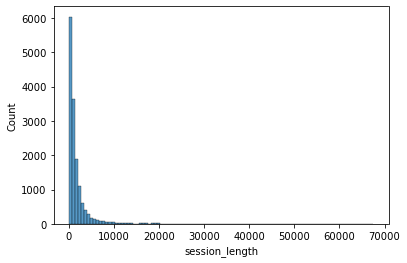

In [118]:
sns.histplot(listen_group_df['session_length'], bins=100)

<AxesSubplot:xlabel='session_length', ylabel='Count'>

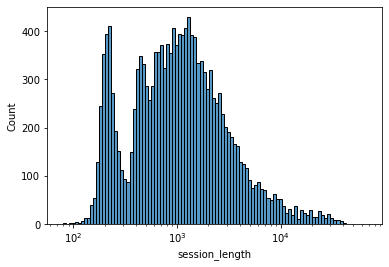

In [119]:
sns.histplot(listen_group_df['session_length'], bins=100, log_scale=True)

<AxesSubplot:xlabel='number_of_songs', ylabel='Count'>

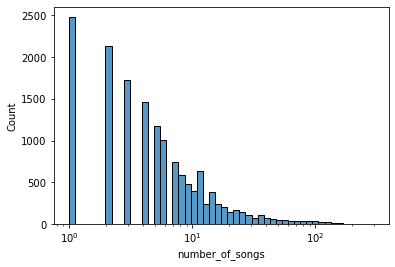

In [121]:
sns.histplot(listen_group_df['number_of_songs'], bins=50, log_scale=True)

<AxesSubplot:xlabel='track_duration', ylabel='Count'>

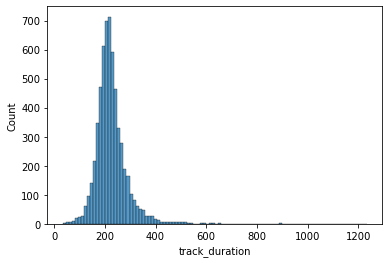

In [123]:
sns.histplot((fourth_merge[['track_name_x', 'artist_name_x', 'track_duration']].drop_duplicates()['track_duration'] / 1000), bins=100)

In [124]:
listen_group_df.to_csv("listen_group.csv")

In [125]:
fourth_merge.to_csv("fourth_merge.csv")

In [6]:
fourth_merge = pd.read_csv("fourth_merge.csv")
listen_group_df = pd.read_csv("listen_group.csv")

In [7]:
listen_group_df['session_start_date'] = pd.to_datetime(listen_group_df['session_start_date'])
listen_group_df['start_of_last_song_date'] = pd.to_datetime(listen_group_df['start_of_last_song_date'])
listen_group_df['session_end_date'] = pd.to_datetime(listen_group_df['session_end_date'])

In [9]:
fourth_merge['date'] = pd.to_datetime(fourth_merge['date'])

In [8]:
import seaborn as sns

In [10]:
listen_group_df = listen_group_df.set_index("session_id")

<AxesSubplot:xlabel='number_of_songs', ylabel='Count'>

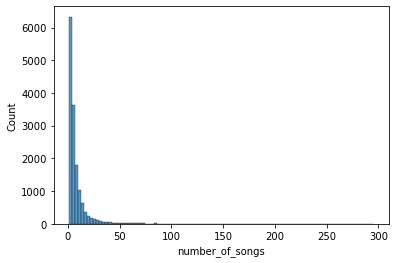

In [11]:
sns.histplot(listen_group_df['number_of_songs'], bins=100)

In [23]:
dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']

In [5]:
import numpy as np
import scipy

In [36]:
cum_observed_frequency

array([    0,  2479,  2479,  4605,  6327,  8957,  9964, 11774, 13559,
       15128], dtype=int64)

session_id
7200       1
9133       1
12630      1
12626      1
5095       1
        ... 
4        174
718      179
1632     208
3328     212
14648    295
Name: number_of_songs, Length: 15128, dtype: int64

In [61]:
param = getattr(scipy.stats, 'invgauss').fit(listen_group_df['number_of_songs'].sort_values())
param

(3.1331577403548074, 0.44088148231741126, 2.5667040178261993)

In [54]:
(cum_expected_frequency - cum_observed_frequency) ** 2 / cum_observed_frequency

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
        2478.98833464,  2478.98833464,  2478.98833464,  2478.98833464,
        2478.98833464,  2478.98833464,  4604.97670903,  4604.97670903,
        4604.97670903,  4604.97670903,  4604.97670903,  4604.97670903,
        6326.96512316,  6326.96512316,  6326.96512316,  6326.96512316,
        6326.96512316,  7783.95357704,  7783.95357704,  7783.95357704,
        7783.95357704,  8956.94207067,  8956.94207067,  8956.94207067,
        9963.93060404,  9963.93060404, 10701.91917715, 10701.91917715,
       11290.90779002, 11290.90779002, 11773.89644263, 12164.88513498,
       12517.87386708, 12796.86263893, 13251.84030187, 13558.81812379,
       13883.78515476, 14192.73100132, 14496.64642259, 14818.44335797,
       15126.28217924])

In [60]:

chi_square_statistics = []
# 11 equi-distant bins of observed Data 
percentile_bins = np.linspace(0,100,50)
percentile_cutoffs = np.percentile(listen_group_df['number_of_songs'].sort_values(), percentile_bins)
observed_frequency, bins = (np.histogram(listen_group_df['number_of_songs'].sort_values(), bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions
for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(listen_group_df['number_of_songs'].sort_values())
    print("{}\n{}\n".format(dist, param))


    # Get expected counts in percentile bins
    # cdf of fitted sistrinution across bins
    cdf_fitted = dist.cdf(percentile_cutoffs, *param)
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)

    # Chi-square Statistics
    expected_frequency = np.array(expected_frequency) * len(listen_group_df)
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss = np.nansum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
    chi_square_statistics.append(ss)


#Sort by minimum ch-square statistics
results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square_statistics
results.sort_values(['chi_square'], inplace=True)


print ('\nDistributions listed by Betterment of fit:')
print ('............................................')
print (results)

(0.5086210166267678, 0.9999999999999999, 4.760494898927868)

(8.48281332628239, 14.936414523298252)

(0.1573950512506729, 295.00000000000006, 1.740472716294306)

(0.5681045416513446, 137.03337917577653, 0.9999999999999999, 960.8904086752116)

(3.1331577403548074, 0.44088148231741126, 2.5667040178261993)

(1.0, 294.0)

(0.1546015472653962, 0.9999999999999999, 1.587130642699377)

(1.0, 7.48281332628239)

(10.716355681800543, 0.9999999999999998, 0.015267044417809947)

(2.3690209781817604, 6.450330282455397, 6.455973388578078)

(0.14106523641462043, -47.28834140926418, 342.31213964838946)


Distributions listed by Betterment of fit:
............................................
   Distribution     chi_square
4      invgauss    5381.146342
9      pearson3    6581.831427
7         expon    7342.680771
0   weibull_min   35096.386232
3          beta   43757.899885
1          norm  164752.553203
8       lognorm  194076.229751
10       triang  280833.363182
5       uniform  299293.218529
2   weib

In [64]:
sns.set_theme()

In [63]:
import matplotlib.pyplot as plt

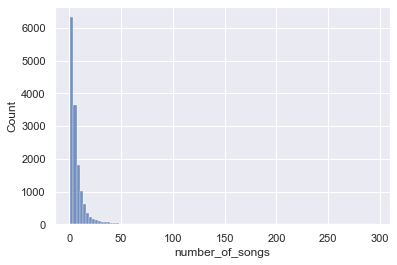

In [65]:
ax = sns.histplot(listen_group_df['number_of_songs'], bins=100)

In [108]:
np.linspace(scipy.stats.invgauss.ppf(.01, .4408814823), scipy.stats.invgauss.ppf(.99, .4408814823), 101)

array([0.09644733, 0.11040192, 0.1243565 , 0.13831108, 0.15226566,
       0.16622024, 0.18017482, 0.19412941, 0.20808399, 0.22203857,
       0.23599315, 0.24994773, 0.26390231, 0.2778569 , 0.29181148,
       0.30576606, 0.31972064, 0.33367522, 0.3476298 , 0.36158439,
       0.37553897, 0.38949355, 0.40344813, 0.41740271, 0.43135729,
       0.44531188, 0.45926646, 0.47322104, 0.48717562, 0.5011302 ,
       0.51508478, 0.52903937, 0.54299395, 0.55694853, 0.57090311,
       0.58485769, 0.59881227, 0.61276686, 0.62672144, 0.64067602,
       0.6546306 , 0.66858518, 0.68253976, 0.69649435, 0.71044893,
       0.72440351, 0.73835809, 0.75231267, 0.76626725, 0.78022184,
       0.79417642, 0.808131  , 0.82208558, 0.83604016, 0.84999474,
       0.86394933, 0.87790391, 0.89185849, 0.90581307, 0.91976765,
       0.93372223, 0.94767682, 0.9616314 , 0.97558598, 0.98954056,
       1.00349514, 1.01744972, 1.03140431, 1.04535889, 1.05931347,
       1.07326805, 1.08722263, 1.10117721, 1.1151318 , 1.12908

In [67]:
invgauss = scipy.stats.invgauss(*param)

In [106]:
param

(3.1331577403548074, 0.44088148231741126, 2.5667040178261993)

In [89]:
invgauss.stats()

(array(8.48277004), array(202.62748847))

In [83]:
x = np.linspace(0, 1, num=101)

In [85]:
scipy.stats.invgauss.fit(listen_group_df['number_of_songs'].sort_values())

(3.1331577403548074, 0.44088148231741126, 2.5667040178261993)

In [87]:
listen_group_df['number_of_songs'].describe()

count    15128.000000
mean         8.482813
std         14.936908
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        295.000000
Name: number_of_songs, dtype: float64

In [97]:
scipy.stats.kstest(listen_group_df['number_of_songs'].sort_values(), 'invgauss', param)

KstestResult(statistic=0.12000856305817705, pvalue=2.6023099014708966e-190)

In [99]:
pparam = scipy.stats.expon.fit(listen_group_df['number_of_songs'].sort_values())

In [110]:
from fitter import Fitter

,sumsquare_error,aic,bic,kl_div
wald,0.000039,5318.547595,-1466.431231,inf
weibull_min,0.000064,3365.264938,-1411.808391,inf
frechet_r,0.000064,3365.264938,-1411.808391,inf
pearson3,0.000076,4148.719500,-1395.830686,inf
gilbrat,0.000078,4897.908379,-1397.073278,inf


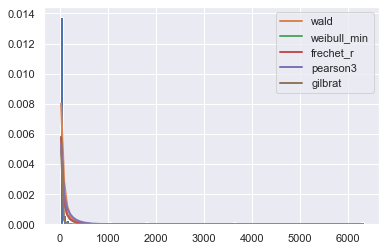

In [116]:
f = Fitter(hist, timeout=90)
f.fit()
f.summary()

In [12]:
hist, bin_edges = np.histogram(listen_group_df['number_of_songs'], bins=100)

In [119]:
scipy.stats.expon.fit(hist[:-1])

(0.0, 152.7979797979798)

In [14]:
import scipy.stats as st

In [122]:
st.expon.fit(hist[:-1])

(0.0, 152.7979797979798)

In [28]:
yt = st.expon.pdf(bin_edges, 0, 152.797979)

<AxesSubplot:>

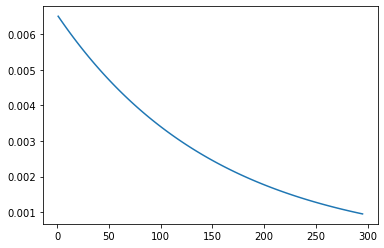

In [29]:
sns.lineplot(x=bin_edges, y = yt)